In [1]:
import sys
import numpy as np
import pandas as pd
# import pyqtgraph as pg
import cnmodel as cnm
from cnmodel import populations
from cnmodel.protocols import IVCurve, VCCurve
from neuron import h
import matplotlib.pyplot as plt

--No graphics will be displayed.


In [2]:
colors = {'stim': 'tab:blue',
          'sgc': 'tab:pink',
          'pyr': 'tab:purple',
          'tcv': 'tab:green'}

## Single Cell with Injected Current

In [2]:
temperature = 34.
cell = cnm.cells.Pyramidal.create(model='POK',
                                      ttx=False, nach=None)
cell.set_temperature(float(temperature))

In [3]:
v0 = cell.find_i0(showinfo=True)
iv = IVCurve()
iv.run({'pulse': [(0, 0.05, 0.01)]},
       cell, durs=[400, 500, 400],
       sites=None, reppulse=None, temp=float(temperature))
# result = iv.input_resistance_tau()
# print('    From IV: Rin = {:7.1f}  Tau = {:7.1f}  Vm = {:7.1f}'.format(result['slope'], result['tau'], result['intercept']))
# iv.show(cell=cell)

# if sys.flags.interactive == 0:  # keeps application alive for display of data
#     pg.QtGui.QApplication.exec_()


  [soma] find_i0  Species: rat  cell type: pyramidal  Temp   32.0
    *** found V0 = -62.496552
    *** and cell has mechanisms:  ['napyr', 'kdpyr', 'kif', 'kis', 'ihpyr', 'leak']


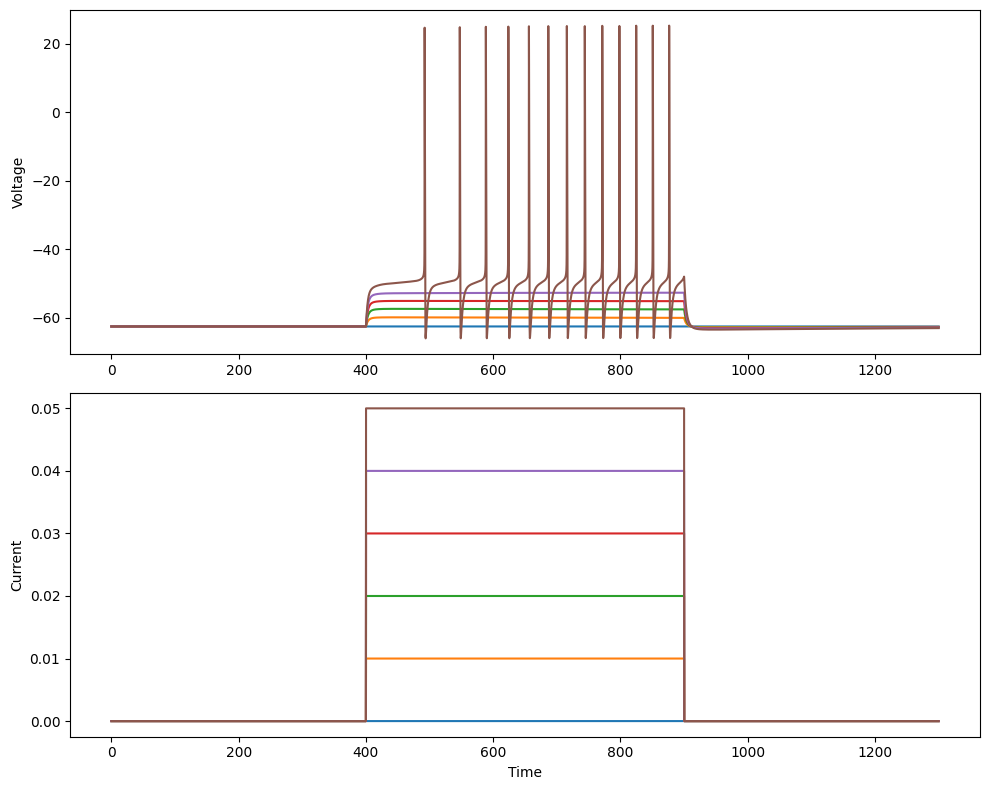

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, axs = plt.subplots(2,1, figsize=(10,8))
axs.ravel()

for i, voltage_trace in enumerate(iv.voltage_traces):

    axs[0].plot(iv.time_values, voltage_trace)
    axs[1].plot(iv.time_values, iv.current_traces[i])

# plt.plot(iv.voltage_traces[0], iv.current_traces[0])
axs[0].set_ylabel('Voltage')
axs[1].set_ylabel('Current')
axs[1].set_xlabel('Time')

fig.tight_layout()

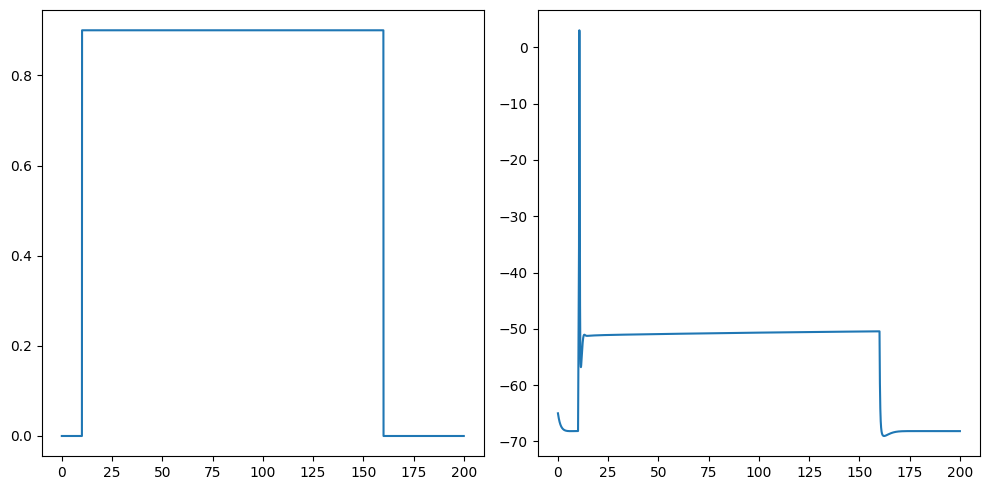

In [6]:
sgc_cell = cnm.cells.SGC.create(cf=4000)

# istim = h.iStim(0.5, sec=sgc_cell.soma)
# stim = {
#     'NP': 10,
#     'Sfreq': 100.0,
#     'delay': 10.0,
#     'dur': 0.5,
#     'amp': 1,
#     'PT': 0.0,
#     'dt': 0.025,
# }

# (secmd, maxt, tstims) = cnm.util.make_pulse(stim)

# istim.delay = 0
# istim.dur = 1e9
# istim.iMax = 0.0

# i_stim_ve = h.Vector(secmd)
# i_stim_ve.play(istim._ref_i, 0.025, 0)

# istim_i = h.Vector().record(istim._ref_i)

ic = h.IClamp(sgc_cell.soma(0.5))
ic.delay = 10
ic.dur = 150
ic.amp = 0.9

istim_i = h.Vector().record(ic._ref_i)

h.tstop = 200
h.celsius = 34
h.dt = 0.025

v_sgc = h.Vector().record(sgc_cell.soma(0.5)._ref_v)
t = h.Vector().record(h._ref_t)

cnm.util.custom_init()
h.run()

fig, axs = plt.subplots(1,2,figsize=(10,5))
axs = axs.ravel()

axs[0].plot(t, istim_i)
axs[1].plot(t, v_sgc)

fig.tight_layout()

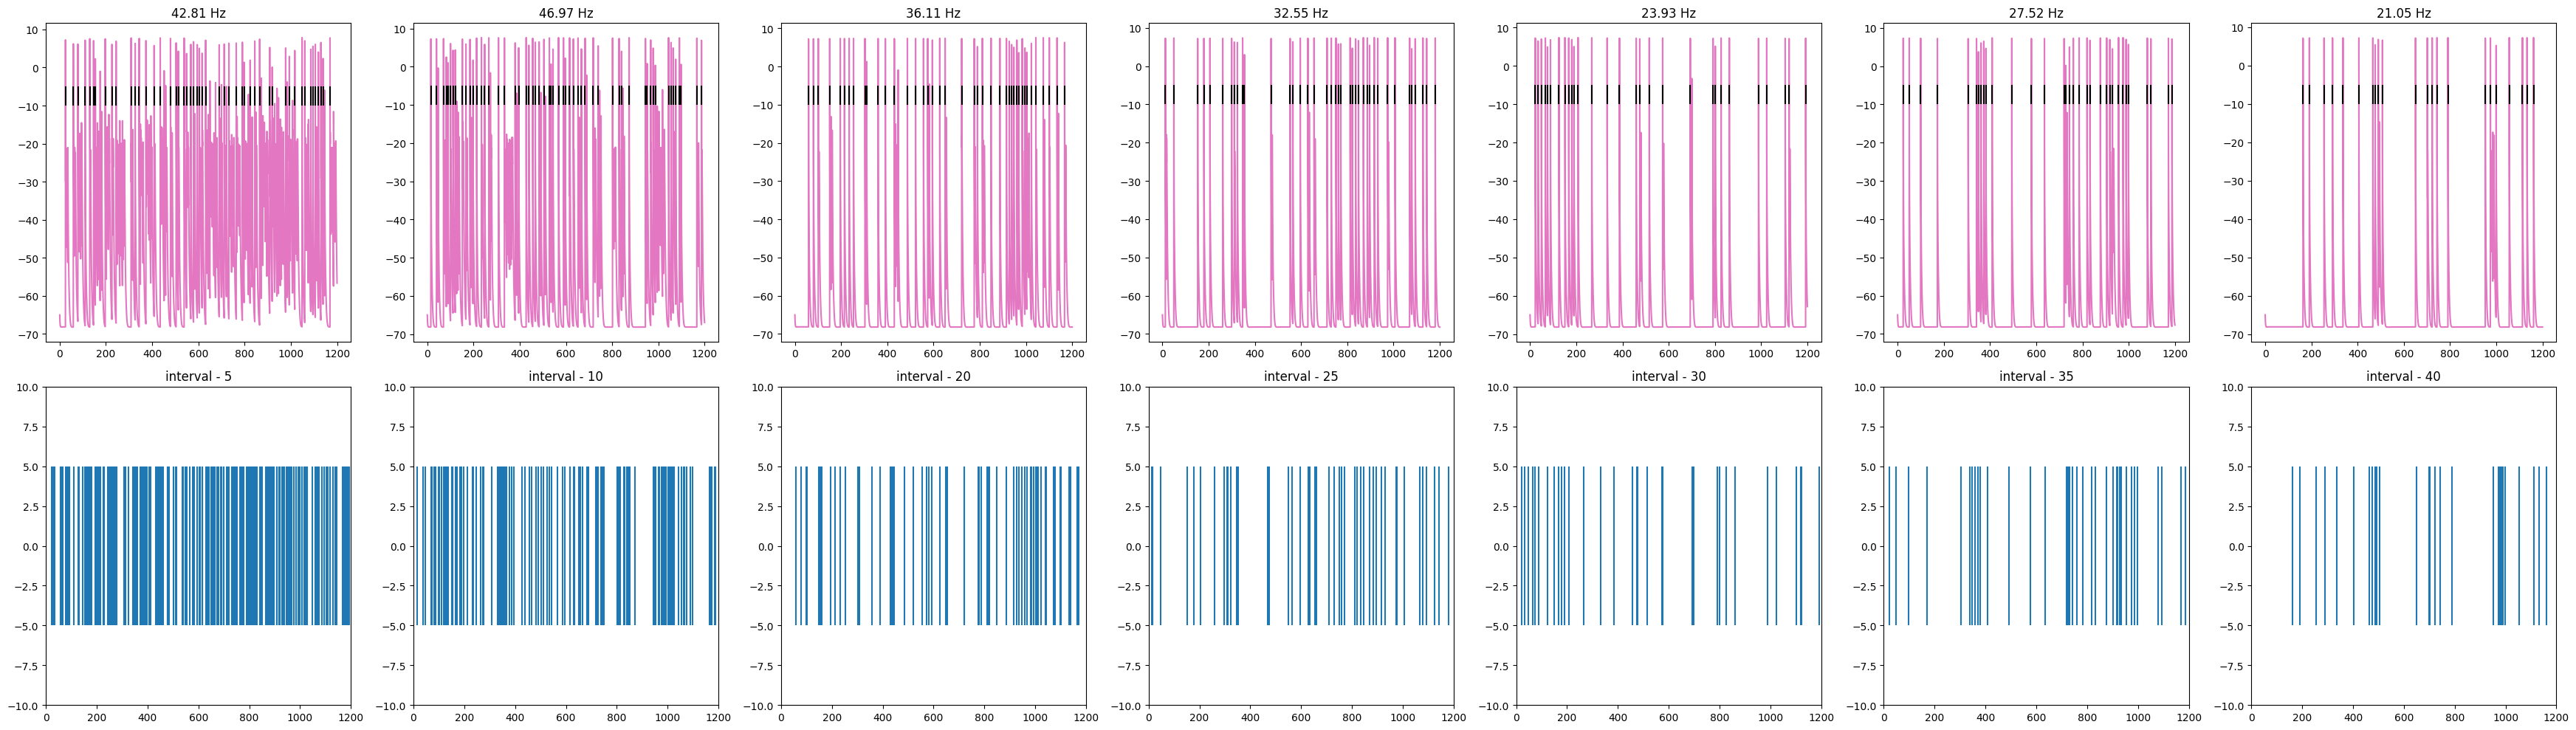

In [33]:
intervals = [5, 10, 20, 25, 30, 35, 40]

fig, axs = plt.subplots(2,len(intervals),figsize=(5*len(intervals),10))
# axs = axs.ravel()

for i, interval in enumerate(intervals):

    sgc_cell = cnm.cells.SGC.create(cf=4000)

    ns = h.NetStim()

    ns.interval = interval
    ns.number = 1e12
    ns.start = 10
    ns.noise = 1

    stim_t = h.Vector()
    stim_id = h.Vector()

    syn = h.Exp2Syn(sgc_cell.soma(0.5))
    syn.tau1 = 0.167
    syn.tau2 = 1.489
    syn.e = 0

    nc = h.NetCon(ns, syn)
    nc.record(stim_t, stim_id)
    nc.weight[0] = 0.2

    h.tstop = 1200
    h.celsius = 34
    h.dt = 0.025

    v_sgc = h.Vector().record(sgc_cell.soma(0.5)._ref_v)
    t = h.Vector().record(h._ref_t)

    cnm.util.custom_init()
    h.run()

    axs[0,i].plot(t, v_sgc, color=colors['sgc'])

    spkt = [t[j] for j in range(len(v_sgc) - 1) if v_sgc[j] <= 0 and v_sgc[j + 1] > 0]
    num_spikes = len(spkt)
    num_isi = num_spikes - 1 if num_spikes > 0 else 0
    msf = num_isi / (spkt[-1] - spkt[0]) * 1000 if num_spikes > 1 else 1
    axs[0,i].vlines(spkt, ymin=-10, ymax=-5, color='k')
    axs[0,i].set_title(f'{round(msf,2)} Hz')

    # axs[0].plot(t, istim_i)
    axs[1,i].vlines([st for st in stim_t], ymin=-5, ymax=5, color=colors['stim'])
    axs[1,i].set_xlim([t[0], t[-1]])
    axs[1,i].set_ylim([-10,10])
    axs[1,i].set_title(f'interval - {interval}')

    

fig.tight_layout()

## Two Cells: 
### Injected Current -> SGC -> Pyramidal

In [2]:
pre_cell = cnm.cells.SGC.create()
post_cell = cnm.cells.Pyramidal.create()

In [3]:
n_synapses = 10

synapses = []
for i in range(n_synapses):

    synapses.append(pre_cell.connect(post_cell, type='simple'))

In [11]:
# vc_amp = -65
# vclamp = h.VClamp(0.5, sec=post_cell.soma)
# vclamp.dur[i] = 200
# vclamp.amp[0] = vc_amp

In [4]:
istim = h.iStim(0.5, sec=pre_cell.soma)
stim = {
    'NP': 10,
    'Sfreq': 100.0,
    'delay': 10.0,
    'dur': 0.5,
    'amp': 10.0,
    'PT': 0.0,
    'dt': 0.025,
}

(secmd, maxt, tstims) = cnm.util.make_pulse(stim)

istim.delay = 0
istim.dur = 1e9
istim.iMax = 0.0

i_stim_ve = h.Vector(secmd)
i_stim_ve.play(istim._ref_i, 0.025, 0)

istim_i = h.Vector().record(istim._ref_i)

In [5]:
h.tstop = 200
h.celsius = 34
h.dt = 0.025

In [6]:
v_pre = h.Vector().record(pre_cell.soma(0.5)._ref_v)
v_post = h.Vector().record(post_cell.soma(0.5)._ref_v)
t = h.Vector().record(h._ref_t)
# i_vc = h.Vector().record(vclamp._ref_i)
cnm.util.custom_init()
h.run()

0.0

Text(0.5, 1.0, 'Post - Pyramidal')

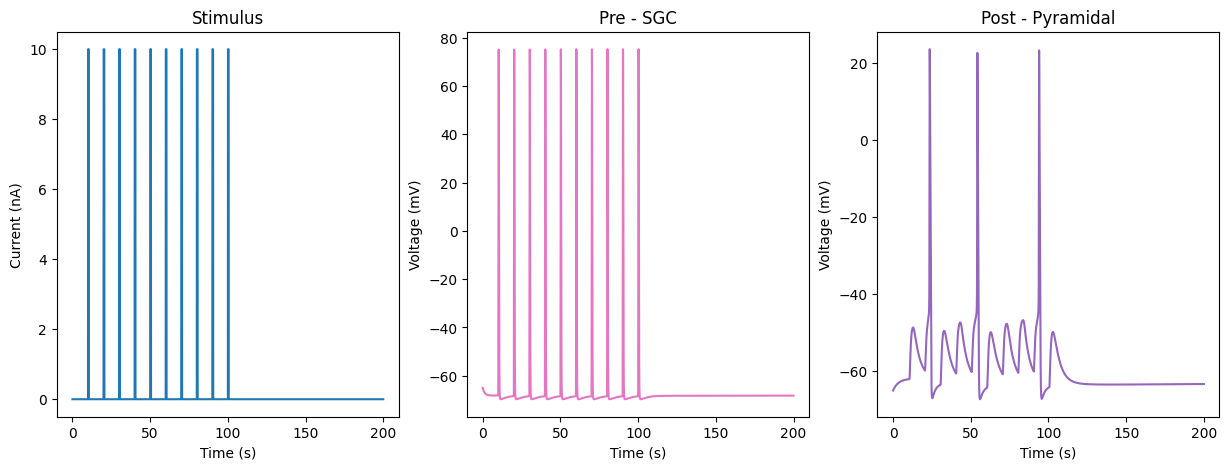

In [10]:
%matplotlib inline

fig, axs = plt.subplots(1,3,figsize=(15,5))
axs.ravel()

axs[0].plot(t, istim_i, color='tab:blue')
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('Current (nA)')
axs[0].set_title('Stimulus')

axs[1].plot(t, v_pre, color='tab:pink')
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('Voltage (mV)')
axs[1].set_title('Pre - SGC')

axs[2].plot(t, v_post, color='tab:purple')
axs[2].set_xlabel('Time (s)')
axs[2].set_ylabel('Voltage (mV)')
axs[2].set_title('Post - Pyramidal')

## Excitatory and Inhibitory Cells

Excitatory - SGC_1 -> PYR_1, SGC_1 -> PYR_2, SGC_1 -> TCV_1 

Inhibitory - TCV_1 -> PYR_2

In [21]:
sgc_cell = cnm.cells.SGC.create()
pyr_cell1 = cnm.cells.Pyramidal.create()
pyr_cell2 = cnm.cells.Pyramidal.create()
tcv_cell = cnm.cells.Tuberculoventral.create()

getcellpars: modelType:  TVmouse


In [22]:
n_synapses = 10

synapses = []
for i in range(n_synapses):
    
    synapses.append(sgc_cell.connect(pyr_cell1, type='simple'))
    synapses.append(sgc_cell.connect(pyr_cell2, type='simple'))

    synapses.append(sgc_cell.connect(tcv_cell, type='simple'))
    synapses.append(tcv_cell.connect(pyr_cell2, type='simple'))

In [ ]:
# vclamp = h.VClamp(0.5, sec=pyr_cell2.soma)
# vclamp.dur[0] = 200
# vclamp.amp[0] = 20

In [23]:
istim = h.iStim(0.5, sec=sgc_cell.soma)
stim = {
    'NP': 10,
    'Sfreq': 100.0,
    'delay': 10.0,
    'dur': 0.5,
    'amp': 10.0,
    'PT': 0.0,
    'dt': 0.025,
}

(secmd, maxt, tstims) = cnm.util.make_pulse(stim)

istim.delay = 0
istim.dur = 1e9
istim.iMax = 0.0

i_stim_ve = h.Vector(secmd)
i_stim_ve.play(istim._ref_i, 0.025, 0)

istim_i = h.Vector().record(istim._ref_i)

In [24]:
h.tstop = 200
h.celsius = 34
h.dt = 0.025

v_sgc = h.Vector().record(sgc_cell.soma(0.5)._ref_v)
v_pyr1 = h.Vector().record(pyr_cell1.soma(0.5)._ref_v)
v_pyr2 = h.Vector().record(pyr_cell2.soma(0.5)._ref_v)
v_tcv = h.Vector().record(tcv_cell.soma(0.5)._ref_v)
t = h.Vector().record(h._ref_t)
# i_vc = h.Vector().record(vclamp._ref_i)
cnm.util.custom_init()
h.run()

0.0

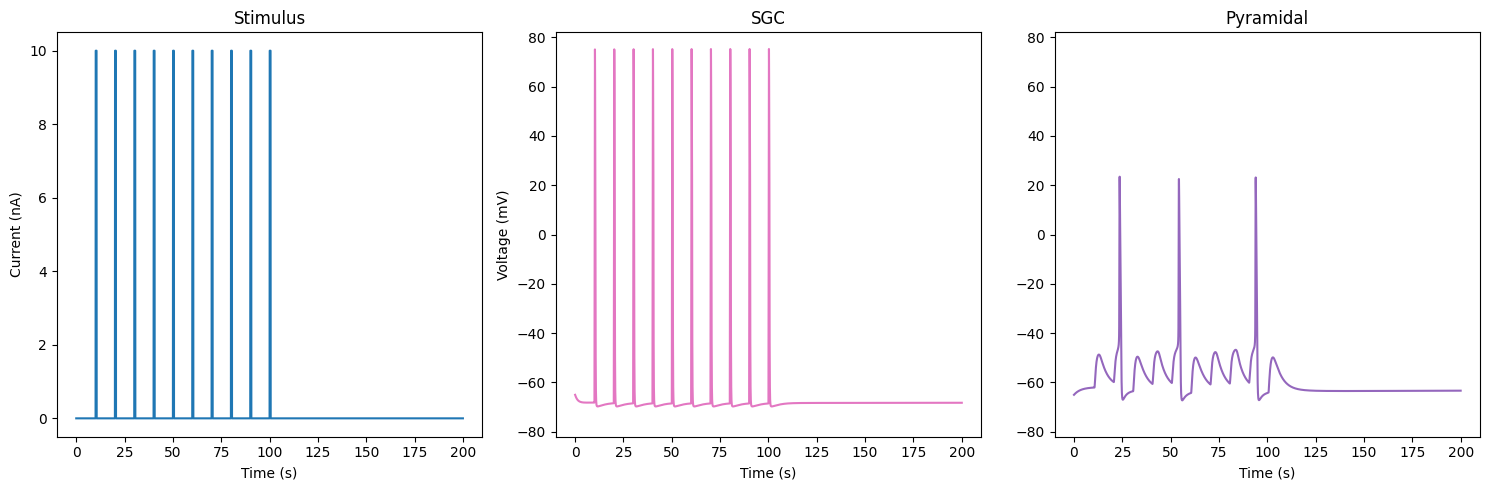

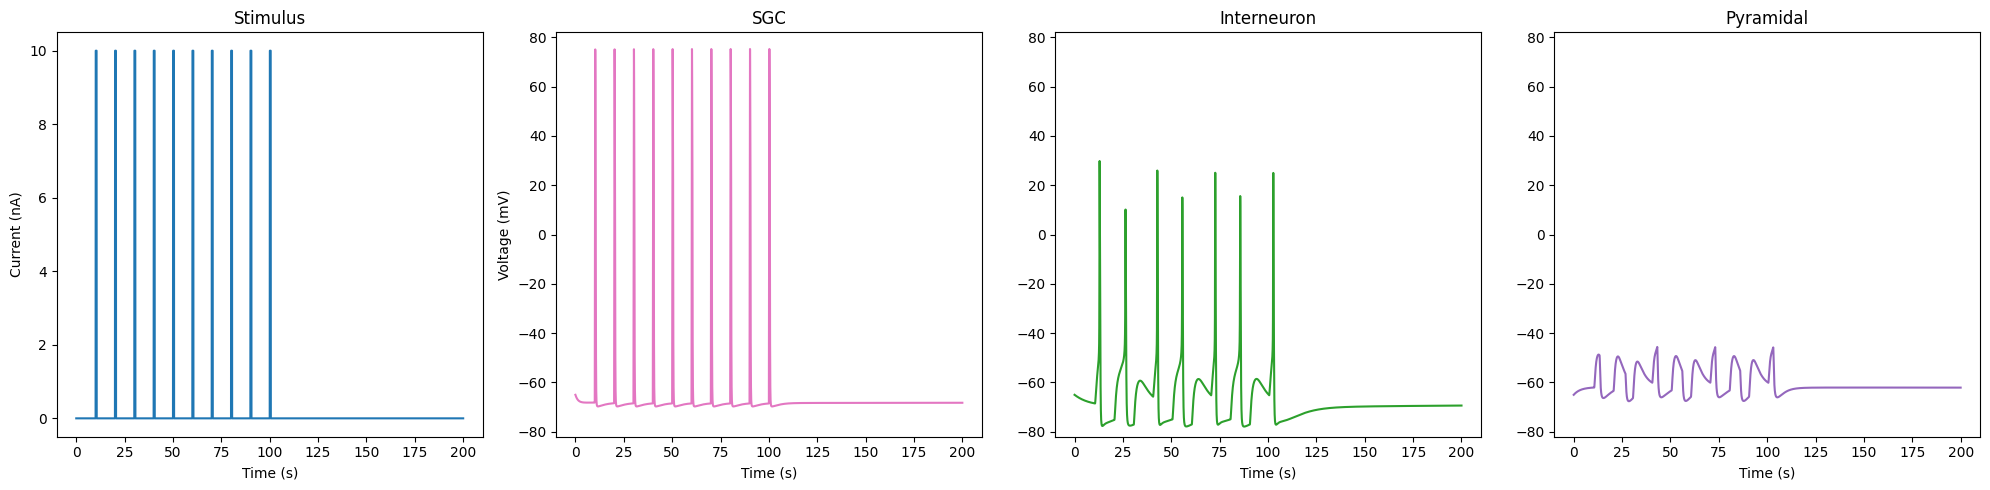

In [30]:
%matplotlib inline

fig, axs = plt.subplots(1,3,figsize=(15,5))  #, sharex=True, sharey=True)

axs[0].plot(t, istim_i, color='tab:blue')
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('Current (nA)')
axs[0].set_title('Stimulus')

axs[1].plot(t, v_sgc, color='tab:pink')
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('Voltage (mV)')
axs[1].set_title('SGC')
axs[1].set_ylim([-82,82])

axs[2].plot(t, v_pyr1, color='tab:purple')
axs[2].set_xlabel('Time (s)')
# axs[2].set_ylabel('Voltage (mV)')
axs[2].set_title('Pyramidal')
axs[2].set_ylim([-82,82])

fig.tight_layout() 

%matplotlib inline

fig, axs = plt.subplots(1,4,figsize=(20,5))  #, sharex=True, sharey=True)

axs[0].plot(t, istim_i, color='tab:blue')
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('Current (nA)')
axs[0].set_title('Stimulus')

axs[1].plot(t, v_sgc, color='tab:pink')
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('Voltage (mV)')
axs[1].set_title('SGC')
axs[1].set_ylim([-82,82])

axs[2].plot(t, v_tcv, color='tab:green')
axs[2].set_xlabel('Time (s)')
# axs[2].set_ylabel('Voltage (mV)')
axs[2].set_title('Interneuron')
axs[2].set_ylim([-82,82])

axs[3].plot(t, v_pyr2, color='tab:purple')
axs[3].set_xlabel('Time (s)')
# axs[3].set_ylabel('Voltage (mV)')
axs[3].set_title('Pyramidal')
axs[3].set_ylim([-82,82])

fig.tight_layout() 

## Populations of Cells

### Based on test_populations.py

In [3]:
sgc_pop = populations.SGC()
pyr_pop = populations.Pyramidal()

In [4]:
sgc_pop.connect(pyr_pop)

In [ ]:
dt = 0.025

cf = 16e3
pyr_cell_id = pyr_pop.select(1, cf=cf, create=True)[0]
pyr_cell = pyr_pop.get_cell(pyr_cell_id)
pyr_sec = pyr_cell.soma

pyr_pop._synapsetype = 'simple'
pyr_pop.resolve_inputs(depth=1)

In [30]:
sgc_cell_ids = pyr_pop.cell_connections(pyr_cell_id)[sgc_pop]
sgc_cells = [sgc_pop.get_cell(i) for i in sgc_cell_ids]
sgc_secs = [cell.soma for cell in sgc_cells]

for i in range(len(sgc_cells)):
    print(sgc_cells[i].cf)

12639.784836328148
13693.316478135668
13995.586104767694
14111.505437510083
14249.110926568497
14416.00988098463
14563.649296180369
14856.269636909079
14885.130862912958
14943.021629670593
15110.71477368253
15154.769456198885
15198.952578374161
15243.264514669032
15258.063850339347
15436.780607908271
15549.540034313013
15594.87409426629
15602.442610358004
15625.170204712376
15701.168226679181
16212.110402546954
16219.978476230694
16370.199515752518
16481.77823991757
16545.878635716937
16545.878635716937
16610.22832869055
16642.49696445759
16878.3269490191
16960.420100353072
17259.275499431897
17351.63854149074
17351.63854149074
17368.484849114568
17588.98101187886
17614.602335124706
17951.09568848956
18038.406594328564
18082.221167602333
18099.776781130302
18178.98820479781
18178.98820479781
18249.689334384508
18553.24970581622
19073.530429747465
19147.710583857115
19353.196958135486


In [31]:
ds_pop = populations.DStellate()
sgc_pop.connect(ds_pop)

ds_cell_id = ds_pop.select(1, cf=cf, create=True)[0]
ds_cell = ds_pop.get_cell(ds_cell_id)
ds_sec = pyr_cell.soma

ds_pop._synapsetype = 'simple'
ds_pop.resolve_inputs(depth=1)

sgc_cell_ids = ds_pop.cell_connections(ds_cell_id)[sgc_pop]
sgc_cells = [sgc_pop.get_cell(i) for i in sgc_cell_ids]
sgc_secs = [cell.soma for cell in sgc_cells]

len(sgc_cells)

for i in range(len(sgc_cells)):
    print(sgc_cells[i].cf)

5995.998407022608
7520.872294863381
7807.171707375927
8147.740318269852
9530.157123407753
10344.557295549997
10465.7224549359
10619.176597933967
11223.105279318668
11988.672387417759
12146.763041661803
12426.947003728208
12856.267968370685
12956.462785810158
14256.0263158617
15030.280203722836
15399.376134819087
15724.039631577592
16911.116419091235
16976.886582971223
17942.38787523396
18797.90526813052
18907.67412542838
19371.986532888423
20138.71881808327
21366.815495185423
22212.50198397928
23294.218095868073
24063.923822789046
25370.850883961666
27753.542006272
29589.224899641777
30879.98185993489
31838.489782010518
34896.24744529241


In [27]:
tcv_pop = populations.Tuberculoventral()
sgc_pop.connect(tcv_pop)

tcv_cell_id = tcv_pop.select(1, cf=cf, create=True)[0]
tcv_cell = tcv_pop.get_cell(tcv_cell_id)
tcv_sec = pyr_cell.soma

tcv_pop._synapsetype = 'simple'
tcv_pop.resolve_inputs(depth=1)

sgc_cell_ids = tcv_pop.cell_connections(tcv_cell_id)[sgc_pop]
sgc_cells = [sgc_pop.get_cell(i) for i in sgc_cell_ids]
sgc_secs = [cell.soma for cell in sgc_cells]

len(sgc_cells)

getcellpars: modelType:  TVmouse


24

In [28]:
for i in range(len(sgc_cells)):
    print(sgc_cells[i].cf)

13833.554536628455
14097.818189387935
14152.646965305978
14367.130094784497
15015.701803466054
15339.717404869596
15369.517823257105
15931.38733717711
16196.38570338952
16251.488974897025
16521.811824735527
16578.022259547768
16772.199608272516
16804.782905109958
17042.912538033153
17769.115937695475
18020.910505914882
18029.656427833004
18073.44974729984
18294.017105043382
18508.293795191785
18616.371489565307
19713.335552074303
21201.581803459954


In [6]:
len(sgc_cells)

48

In [12]:
stim = {
    'NP': 10,
    'Sfreq': 100.0,
    'delay': 10.0,
    'dur': 0.5,
    'amp': 10.0,
    'PT': 0.0,
    'dt': dt,
}

(secmd, maxt, tstims) = cnm.util.make_pulse(stim)

v_sgcs = {}

# stim_dur = 10
# stim_delay = 50
# sim_dur = 100

# stim = cnm.util.sound.TonePip(rate=100e3, duration=sim_dur, f0=cf, dbspl=60,
#                               ramp_duration=2.5e-3, pip_duration=stim_dur, pip_start=[stim_delay])

istims = []

for i, sgc_cell in enumerate(sgc_cells):
    istim = h.iStim(0.5, sec=sgc_cell.soma)

    (secmd, maxt, tstims) = cnm.util.make_pulse(stim)

    i_stim_vec = h.Vector(secmd)
    i_stim_vec.play(istim._ref_i, dt, 0, sgc_cell.soma(0.5))

    istim_i = h.Vector().record(istim._ref_i)
    istims.append((istim, i_stim_vec))

    # sgc_cell.set_sound_stim(stim, seed=0, simulator='cochlea')

    v_sgcs[i] = h.Vector().record(sgc_cell.soma(0.5)._ref_v)

In [9]:
t = h.Vector().record(h._ref_t)
v_pyr = h.Vector().record(pyr_cell.soma(0.5)._ref_v)

In [13]:
h.tstop = 200
h.celsius = 34
h.dt = dt

pyr_cell.cell_initialize()
cnm.util.custom_init()
h.run()

0.0

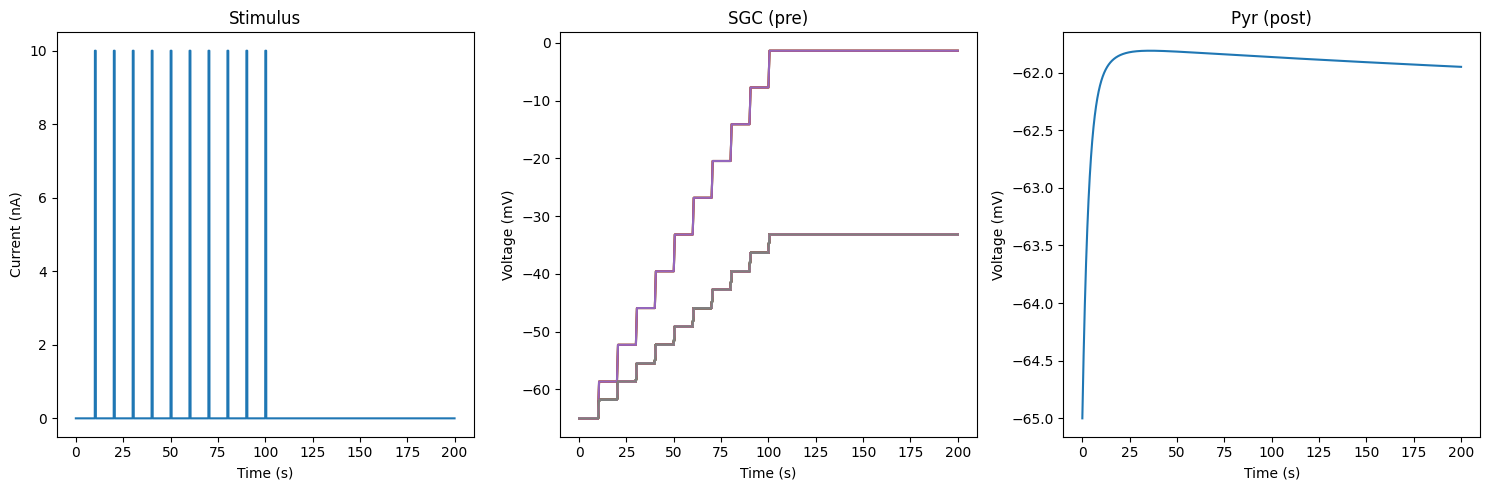

In [14]:
fig, axs = plt.subplots(1,3,figsize=(15,5))
axs.ravel()

axs[0].plot(t, istim_i)
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('Current (nA)')
axs[0].set_title('Stimulus')

for i, v_sgc in v_sgcs.items():

    axs[1].plot(t, v_sgc)

axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('Voltage (mV)')
axs[1].set_title('SGC (pre)')

axs[2].plot(t, v_pyr)
axs[2].set_xlabel('Time (s)')
axs[2].set_ylabel('Voltage (mV)')
axs[2].set_title('Pyr (post)')

fig.tight_layout()

### From scratch, i.e. not based on species population data

#### Simple Synaptic Connections

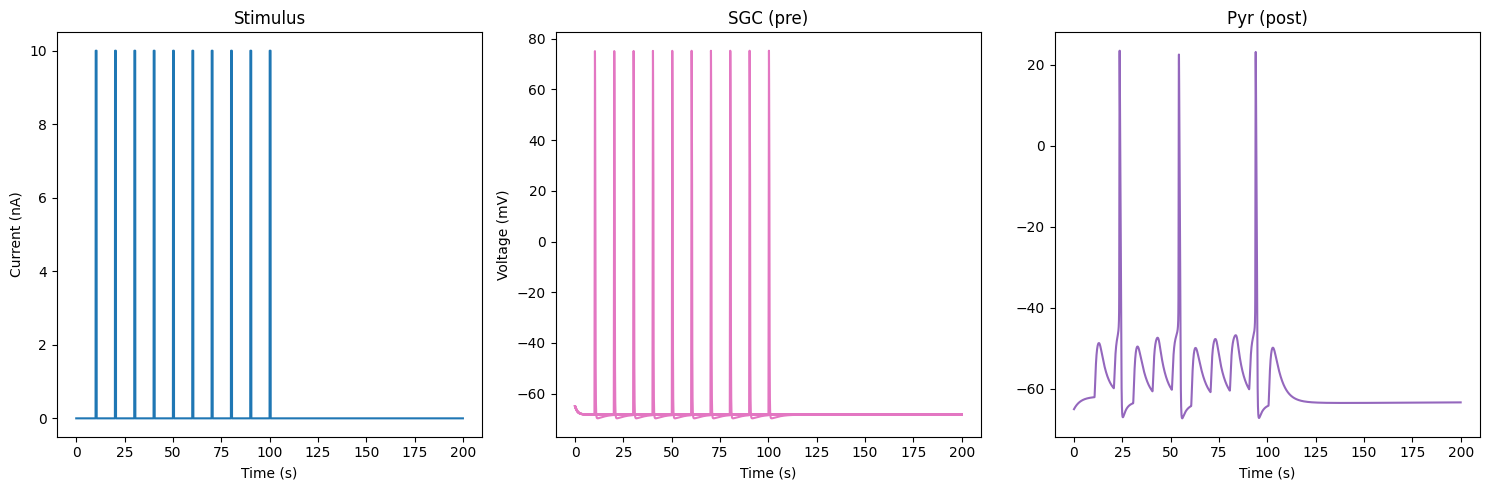

In [17]:
num_sgc = 10

sgc_cells = []
for i in range(num_sgc):
    sgc_cells.append(cnm.cells.SGC.create())

pyr_cell = cnm.cells.Pyramidal.create()

n_synapses = 10
synapses = []

for sgc_cell in sgc_cells:
    
    for i in range(n_synapses):

        synapses.append(sgc_cell.connect(pyr_cell, type='simple'))

dt = 0.025

stim = {
    'NP': 10,
    'Sfreq': 100.0,
    'delay': 10.0,
    'dur': 0.5,
    'amp': 10.0,
    'PT': 0.0,
    'dt': dt,
}

istim = h.iStim(0.5, sec=sgc_cell.soma)

istims = []

for i, sgc_cell in enumerate(sgc_cells):

    (secmd, maxt, tstims) = cnm.util.make_pulse(stim)

    istim.delay = 0
    istim.dur = 1e9
    istim.iMax = 0.0

    i_stim_vec = h.Vector(secmd)
    i_stim_vec.play(istim._ref_i, dt, 0)
    
    istims.append((istim, i_stim_vec))

istim_i = h.Vector().record(istim._ref_i)

t = h.Vector().record(h._ref_t)
v_pyr = h.Vector().record(pyr_cell.soma(0.5)._ref_v)

v_sgcs = {}
for i, sgc_cell in enumerate(sgc_cells):
    v_sgcs[i] = h.Vector().record(sgc_cell.soma(0.5)._ref_v)

h.tstop = 200
h.celsius = 34
h.dt = dt

cnm.util.custom_init()
h.run()

fig, axs = plt.subplots(1,3,figsize=(15,5))
axs.ravel()

axs[0].plot(t, istim_i, color=colors['stim'])
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('Current (nA)')
axs[0].set_title('Stimulus')

for i, v_sgc in v_sgcs.items():

    axs[1].plot(t, v_sgc, color=colors['sgc'])

axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('Voltage (mV)')
axs[1].set_title('SGC (pre)')

axs[2].plot(t, v_pyr, color=colors['pyr'])
axs[2].set_xlabel('Time (s)')
# axs[2].set_ylabel('Voltage (mV)')
axs[2].set_title('Pyr (post)')

fig.tight_layout()

#### Multisite Synaptic Connections

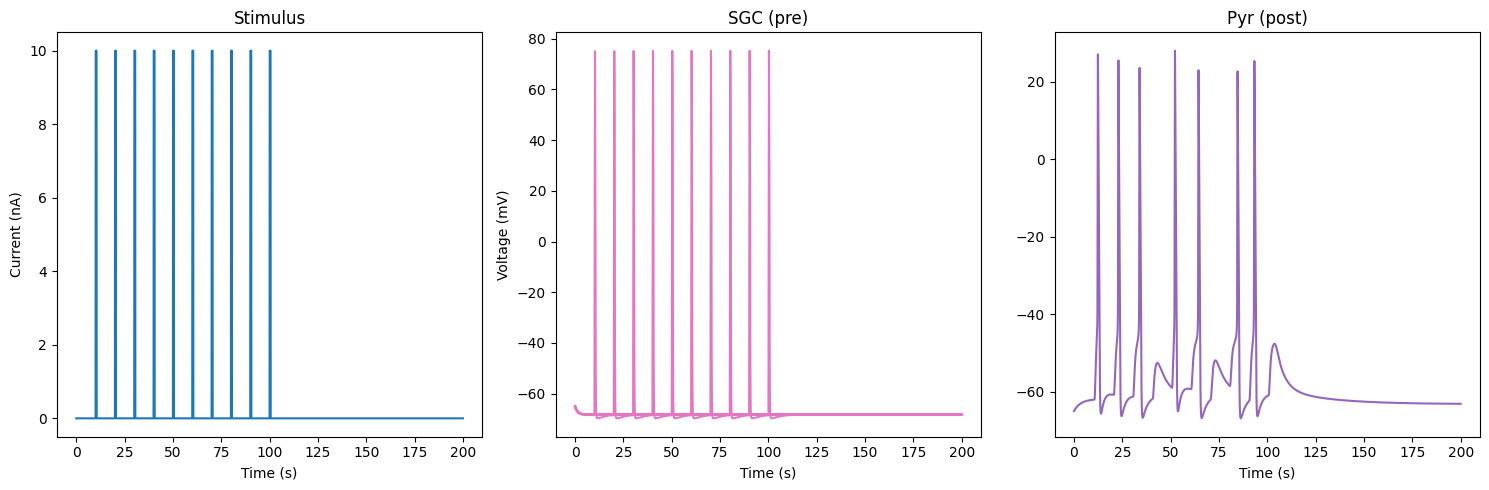

In [18]:
num_sgc = 10

sgc_cells = []
for i in range(num_sgc):
    sgc_cells.append(cnm.cells.SGC.create())

pyr_cell = cnm.cells.Pyramidal.create()

n_synapses = 10
synapses = []

for sgc_cell in sgc_cells:
    
    for i in range(n_synapses):

        synapses.append(sgc_cell.connect(pyr_cell, type='multisite'))

dt = 0.025

stim = {
    'NP': 10,
    'Sfreq': 100.0,
    'delay': 10.0,
    'dur': 0.5,
    'amp': 10.0,
    'PT': 0.0,
    'dt': dt,
}

istim = h.iStim(0.5, sec=sgc_cell.soma)

istims = []

for i, sgc_cell in enumerate(sgc_cells):

    (secmd, maxt, tstims) = cnm.util.make_pulse(stim)

    istim.delay = 0
    istim.dur = 1e9
    istim.iMax = 0.0

    i_stim_vec = h.Vector(secmd)
    i_stim_vec.play(istim._ref_i, dt, 0)
    
    istims.append((istim, i_stim_vec))

istim_i = h.Vector().record(istim._ref_i)

t = h.Vector().record(h._ref_t)
v_pyr = h.Vector().record(pyr_cell.soma(0.5)._ref_v)

v_sgcs = {}
for i, sgc_cell in enumerate(sgc_cells):
    v_sgcs[i] = h.Vector().record(sgc_cell.soma(0.5)._ref_v)

h.tstop = 200
h.celsius = 34
h.dt = dt

cnm.util.custom_init()
h.run()

fig, axs = plt.subplots(1,3,figsize=(15,5))
axs.ravel()

axs[0].plot(t, istim_i, color=colors['stim'])
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('Current (nA)')
axs[0].set_title('Stimulus')

for i, v_sgc in v_sgcs.items():

    axs[1].plot(t, v_sgc, color=colors['sgc'])

axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('Voltage (mV)')
axs[1].set_title('SGC (pre)')

axs[2].plot(t, v_pyr, color=colors['pyr'])
axs[2].set_xlabel('Time (s)')
# axs[2].set_ylabel('Voltage (mV)')
axs[2].set_title('Pyr (post)')

fig.tight_layout()

## Sound Stimuli

### SGC -> Pyr

In [3]:
cf = 4000
# TODO: non Dummy SGC - might not need to do this since we aren't really focusing on model SGC
sgc_cell = cnm.cells.DummySGC(cf=cf, sr=0)
pyr_cell = cnm.cells.Pyramidal.create()

In [4]:
n_synapses = 10
synapses = []

for i in range(n_synapses):
    synapses.append(sgc_cell.connect(pyr_cell))

In [12]:
stim = cnm.util.sound.TonePip(rate=100e3, duration=100, f0=cf, dbspl=80,
                              ramp_duration=2.5e-3, pip_duration=20, pip_start=[40])
sgc_cell.set_sound_stim(stim, seed=74, simulator='cochlea')

In [6]:
v_sgc = h.Vector().record(sgc_cell.soma(0.5)._ref_v)
v_pyr = h.Vector().record(pyr_cell.soma(0.5)._ref_v)
t = h.Vector().record(h._ref_t)

In [7]:
# might not be necessary

# xmtrs = []
# for i in range(30):
#     xmtrs.append(synapse.terminal.relsite._ref_XMTR)
#     synapse.terminal.relsite.Dep_Flag = False

In [8]:
h.tstop = 100
h.celsius = 34
h.dt = 0.025

cnm.util.custom_init()
h.run()

0.0

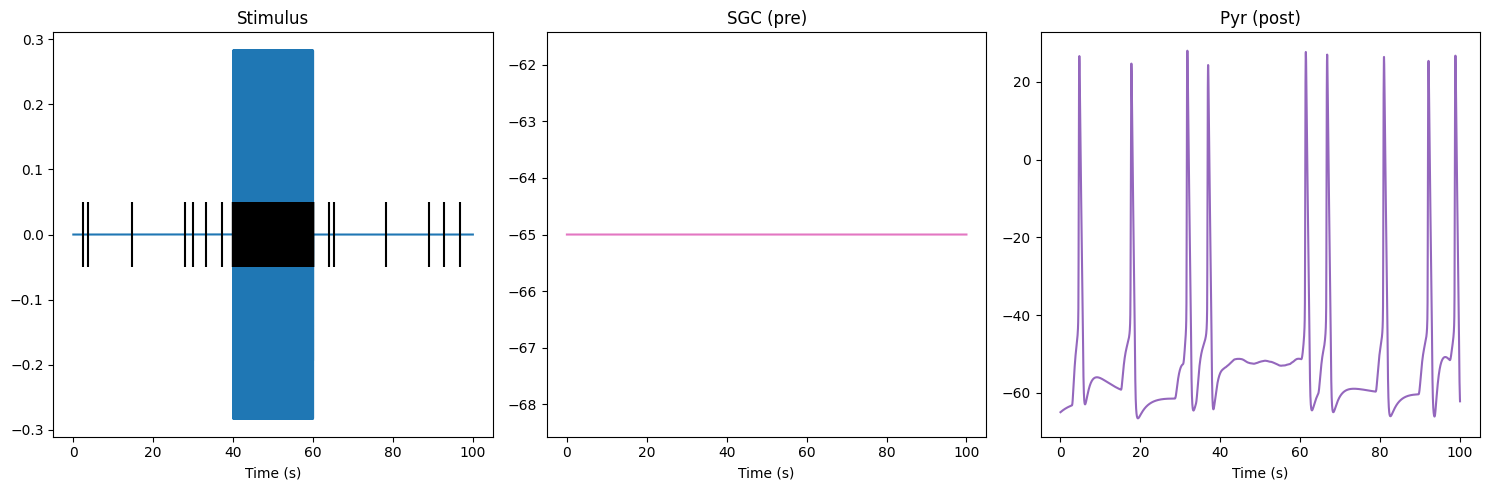

In [10]:
fig, axs = plt.subplots(1,3,figsize=(15,5))
axs.ravel()

axs[0].plot(stim.time, stim.sound, color=colors['stim'])
axs[0].vlines(sgc_cell._spiketrain, ymin=-0.05, ymax=0.05, color='k', zorder=12)
axs[0].set_xlabel('Time (s)')
axs[0].set_title('Stimulus')

axs[1].plot(t, v_sgc, color=colors['sgc'])
axs[1].set_xlabel('Time (s)')
axs[1].set_title('SGC (pre)')

axs[2].plot(t, v_pyr, color=colors['pyr'])
axs[2].set_xlabel('Time (s)')
axs[2].set_title('Pyr (post)')

fig.tight_layout()

In [11]:
temp = 5

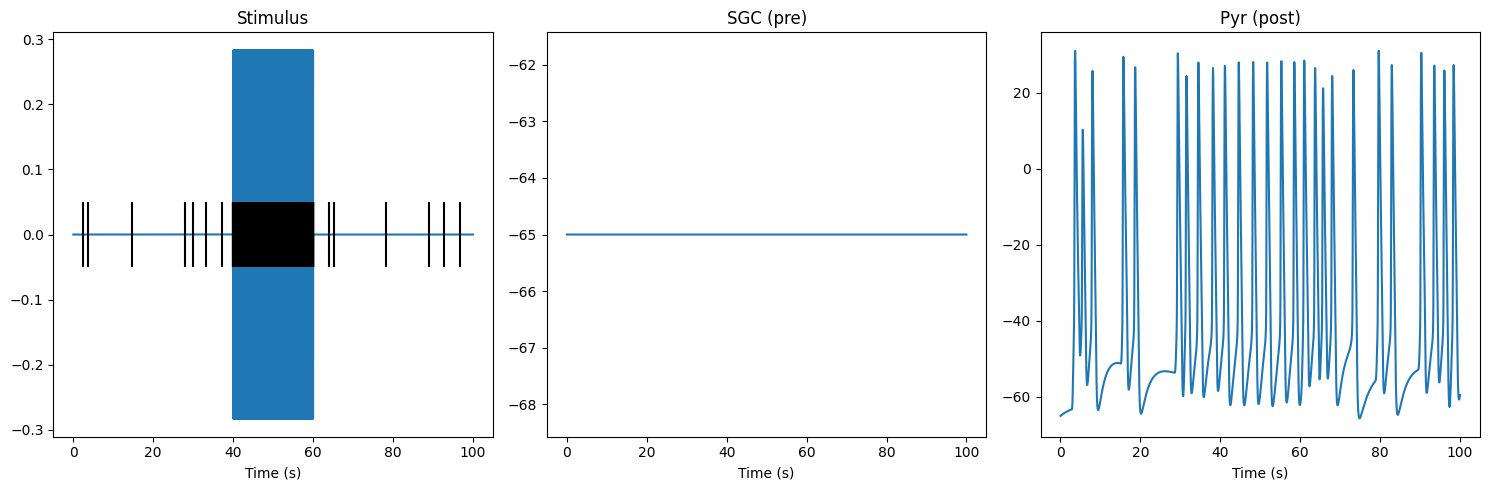

In [16]:
cf = 4000
# TODO: non Dummy SGC - might not need to do this since we aren't really focusing on model SGC
sgc_cell = cnm.cells.DummySGC(cf=cf, sr=0)
pyr_cell = cnm.cells.Pyramidal.create()

n_synapses = 40
synapses = []

xmtrs = []

for i in range(n_synapses):
    synapse = sgc_cell.connect(pyr_cell, type='multisite')
    # for j in range(synapse.terminal.n_rzones):
    #     xmtrs.append(h.Vector().record(synapse.terminal.relsite._ref_XMTR[i]))
    # synapse.terminal.relsite.Dep_Flag = False
    synapses.append(synapse)

stim = cnm.util.sound.TonePip(rate=100e3, duration=100, f0=cf, dbspl=80,
                              ramp_duration=2.5e-3, pip_duration=20, pip_start=[40])
sgc_cell.set_sound_stim(stim, seed=74, simulator='cochlea')

v_sgc = h.Vector().record(sgc_cell.soma(0.5)._ref_v)
v_pyr = h.Vector().record(pyr_cell.soma(0.5)._ref_v)
t = h.Vector().record(h._ref_t)

h.tstop = 100
h.celsius = 34
h.dt = 0.025

pyr_cell.cell_initialize()

cnm.util.custom_init()
h.run()

fig, axs = plt.subplots(1,3,figsize=(15,5))
axs.ravel()

axs[0].plot(stim.time, stim.sound, zorder=1)
axs[0].vlines(sgc_cell._spiketrain, ymin=-0.05, ymax=0.05, color='k', zorder=12)
axs[0].set_xlabel('Time (s)')
axs[0].set_title('Stimulus')

axs[1].plot(t, v_sgc)
axs[1].set_xlabel('Time (s)')
axs[1].set_title('SGC (pre)')

axs[2].plot(t, v_pyr)
axs[2].set_xlabel('Time (s)')
axs[2].set_title('Pyr (post)')

fig.tight_layout()

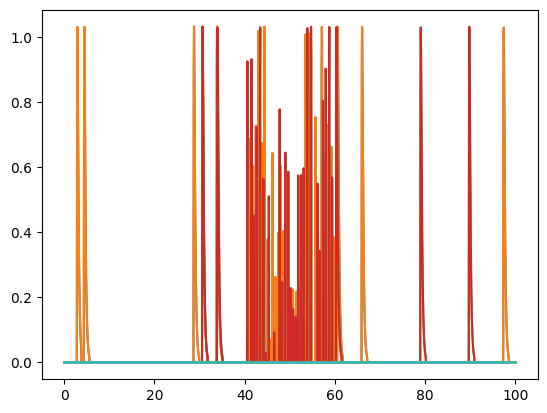

In [17]:
for xmtr in xmtrs:
    plt.plot(t, xmtr)

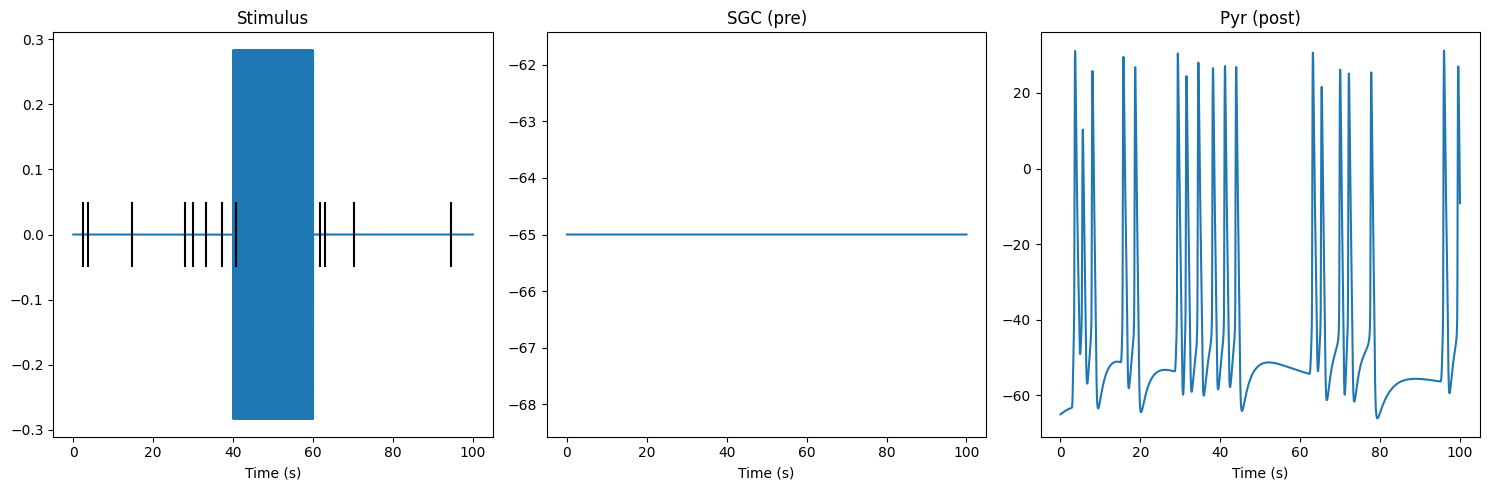

In [17]:
cf = 4000
# TODO: non Dummy SGC - might not need to do this since we aren't really focusing on model SGC
sgc_cell = cnm.cells.DummySGC(cf=cf, sr=0)
pyr_cell = cnm.cells.Pyramidal.create()

n_synapses = 40
synapses = []

xmtrs = []

for i in range(n_synapses):
    synapse = sgc_cell.connect(pyr_cell, type='multisite')
    # for j in range(synapse.terminal.n_rzones):
    #     xmtrs.append(h.Vector().record(synapse.terminal.relsite._ref_XMTR[i]))
    # synapse.terminal.relsite.Dep_Flag = False
    synapses.append(synapse)

stim = cnm.util.sound.TonePip(rate=100e3, duration=100, f0=16e3, dbspl=80,
                              ramp_duration=2.5e-3, pip_duration=20, pip_start=[40])
sgc_cell.set_sound_stim(stim, seed=74, simulator='cochlea')

v_sgc = h.Vector().record(sgc_cell.soma(0.5)._ref_v)
v_pyr = h.Vector().record(pyr_cell.soma(0.5)._ref_v)
t = h.Vector().record(h._ref_t)

h.tstop = 100
h.celsius = 34
h.dt = 0.025

pyr_cell.cell_initialize()

cnm.util.custom_init()
h.run()

fig, axs = plt.subplots(1,3,figsize=(15,5))
axs.ravel()

axs[0].plot(stim.time, stim.sound, zorder=1)
axs[0].vlines(sgc_cell._spiketrain, ymin=-0.05, ymax=0.05, color='k', zorder=12)
axs[0].set_xlabel('Time (s)')
axs[0].set_title('Stimulus')

axs[1].plot(t, v_sgc)
axs[1].set_xlabel('Time (s)')
axs[1].set_title('SGC (pre)')

axs[2].plot(t, v_pyr)
axs[2].set_xlabel('Time (s)')
axs[2].set_title('Pyr (post)')

fig.tight_layout()

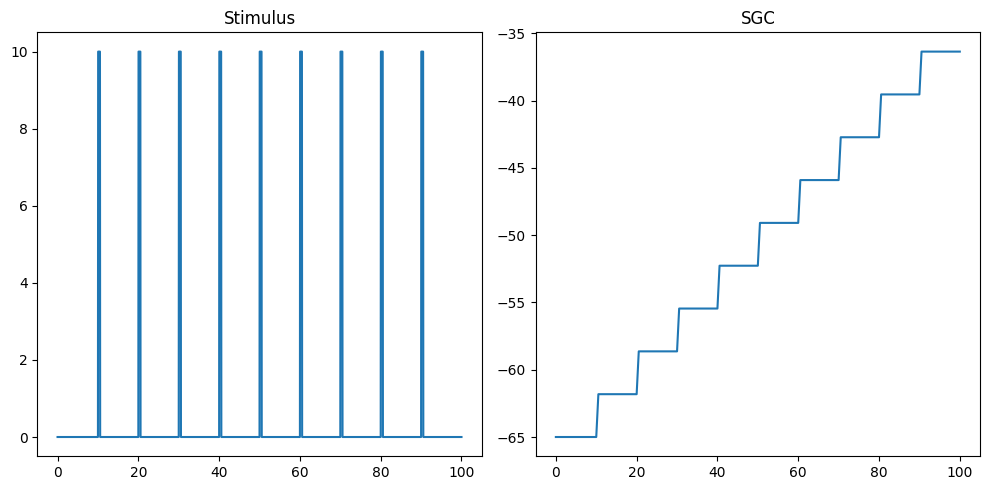

In [22]:
pre_cell = cnm.cells.DummySGC(cf=4000, sr=0)
istim = h.iStim(0.5, sec=pre_cell.soma)
stim = {
    'NP': 10,
    'Sfreq': 100.0,
    'delay': 10.0,
    'dur': 0.5,
    'amp': 10.0,
    'PT': 0.0,
    'dt': 0.025,
}

(secmd, maxt, tstims) = cnm.util.make_pulse(stim)

istim.delay = 0
istim.dur = 1e9
istim.iMax = 0.0

i_stim_ve = h.Vector(secmd)
i_stim_ve.play(istim._ref_i, 0.025, 0)

i_stim_i = h.Vector().record(istim._ref_i)

# stim = cnm.util.sound.TonePip(rate=100e3, duration=100, f0=4000, dbspl=80,
#                               ramp_duration=2.5e-3, pip_duration=20, pip_start=[40])

# pre_cell.set_sound_stim(stim, seed=74, simulator='cochlea')



v_pre = h.Vector().record(pre_cell.soma(0.5)._ref_v)
t = h.Vector().record(h._ref_t)

h.tstop = 100
h.celsius = 34.0
h.dt = 0.025

cnm.util.custom_init()
h.run()

fig, axs = plt.subplots(1,2,figsize=(10,5))
axs = axs.ravel()

axs[0].plot(t, i_stim_i)
# axs[0].plot(stim.time, stim.sound)
# axs[0].vlines(pre_cell._spiketrain, ymin=-0.05, ymax=0.05, color='k')
axs[0].set_title('Stimulus')

axs[1].plot(t, v_pre)
axs[1].set_title('SGC')

fig.tight_layout()

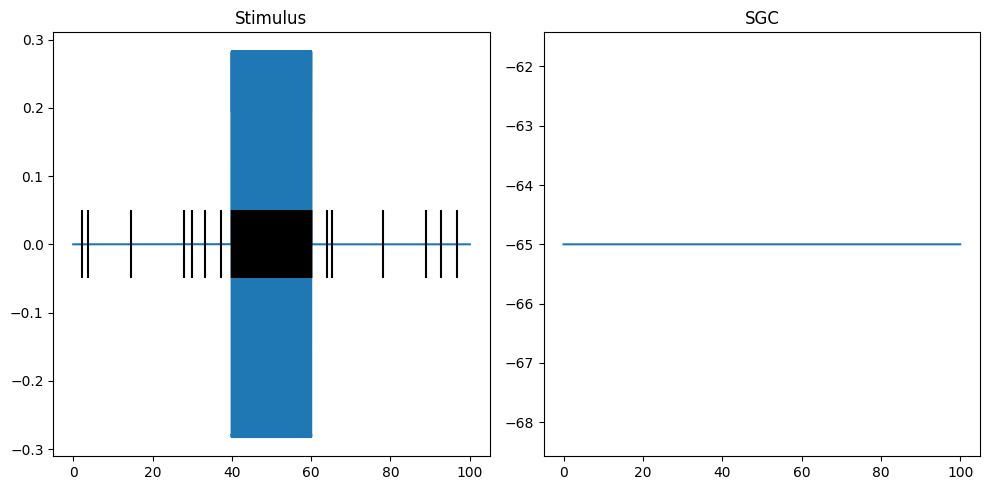

In [19]:
pre_cell = cnm.cells.DummySGC(cf=4000, sr=0)
# istim = h.iStim(0.5, sec=pre_cell.soma)
# stim = {
#     'NP': 10,
#     'Sfreq': 100.0,
#     'delay': 10.0,
#     'dur': 0.5,
#     'amp': 10.0,
#     'PT': 0.0,
#     'dt': 0.025,
# }

# (secmd, maxt, tstims) = cnm.util.make_pulse(stim)

# istim.delay = 0
# istim.dur = 1e9
# istim.iMax = 0.0

# i_stim_ve = h.Vector(secmd)
# i_stim_ve.play(istim._ref_i, 0.025, 0)

# i_stim_i = h.Vector().record(istim._ref_i)

stim = cnm.util.sound.TonePip(rate=100e3, duration=100, f0=4000, dbspl=80,
                              ramp_duration=2.5e-3, pip_duration=20, pip_start=[40])

pre_cell.set_sound_stim(stim, seed=74, simulator='cochlea')



v_pre = h.Vector().record(pre_cell.soma(0.5)._ref_v)
t = h.Vector().record(h._ref_t)

h.tstop = 100
h.celsius = 34.0
h.dt = 0.025

cnm.util.custom_init()
h.run()

fig, axs = plt.subplots(1,2,figsize=(10,5))
axs = axs.ravel()

# axs[0].plot(t, i_stim_i)
axs[0].plot(stim.time, stim.sound)
axs[0].vlines(pre_cell._spiketrain, ymin=-0.05, ymax=0.05, color='k')
axs[0].set_title('Stimulus')

axs[1].plot(t, v_pre)
axs[1].set_title('SGC')

fig.tight_layout()

### Tonotopic Mapping - SGC -> PYR, many of each

In [3]:
# _get_cf_array()
#       s = (fmax / fmin) ** (1./size)
#       freqs = fmin * s**np.arange(size)
#       freqs = freqs[freqs<=40e3]

n_cells = 20
cf_min = 1000
cf_max = 20000

s = (cf_max / cf_min) ** (1./n_cells)
freqs = cf_min * s**np.arange(n_cells)
freqs = freqs[freqs<=40e3]

In [4]:
sgc_cells = []
pyr_cells = []

for i in range(n_cells):

    sgc_cells.append(cnm.cells.DummySGC(cf=freqs[i], sr=2))
    pyr_cells.append(cnm.cells.Pyramidal.create())

In [5]:
n_synapses = 10
synapses = []

for sgc_cell, pyr_cell in zip(sgc_cells, pyr_cells):

    for i in range(n_synapses):
        synapses.append(sgc_cell.connect(pyr_cell))

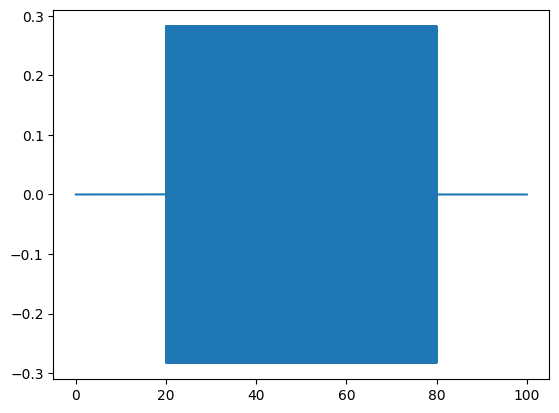

In [17]:
stims = []

cf = 4000

stim = cnm.util.sound.TonePip(rate=100e3, duration=100, f0=cf, dbspl=80,
                              ramp_duration=2.5e-3, pip_duration=60, pip_start=[20])

for sgc_cell in sgc_cells:

    sgc_cell.set_sound_stim(stim, seed=74, simulator='cochlea')

    stims.append(stim)

plt.plot(stim.time, stim.sound);

In [18]:
v_sgcs = []
v_pyrs = []

for sgc_cell, pyr_cell in zip(sgc_cells, pyr_cells):

    v_sgcs.append(h.Vector().record(sgc_cell.soma(0.5)._ref_v))
    v_pyrs.append(h.Vector().record(pyr_cell.soma(0.5)._ref_v))

t = h.Vector().record(h._ref_t)

In [19]:
h.tstop = 100
h.celsius = 34
h.dt = 0.025

cnm.util.custom_init()
h.run()

0.0

In [20]:
spkts = []

for v_pyr in v_pyrs:

    spkt = [t[j] for j in range(len(v_pyr) - 1) if v_pyr[j] <= 0 and v_pyr[j + 1] > 0]
    spkts.append(spkt)

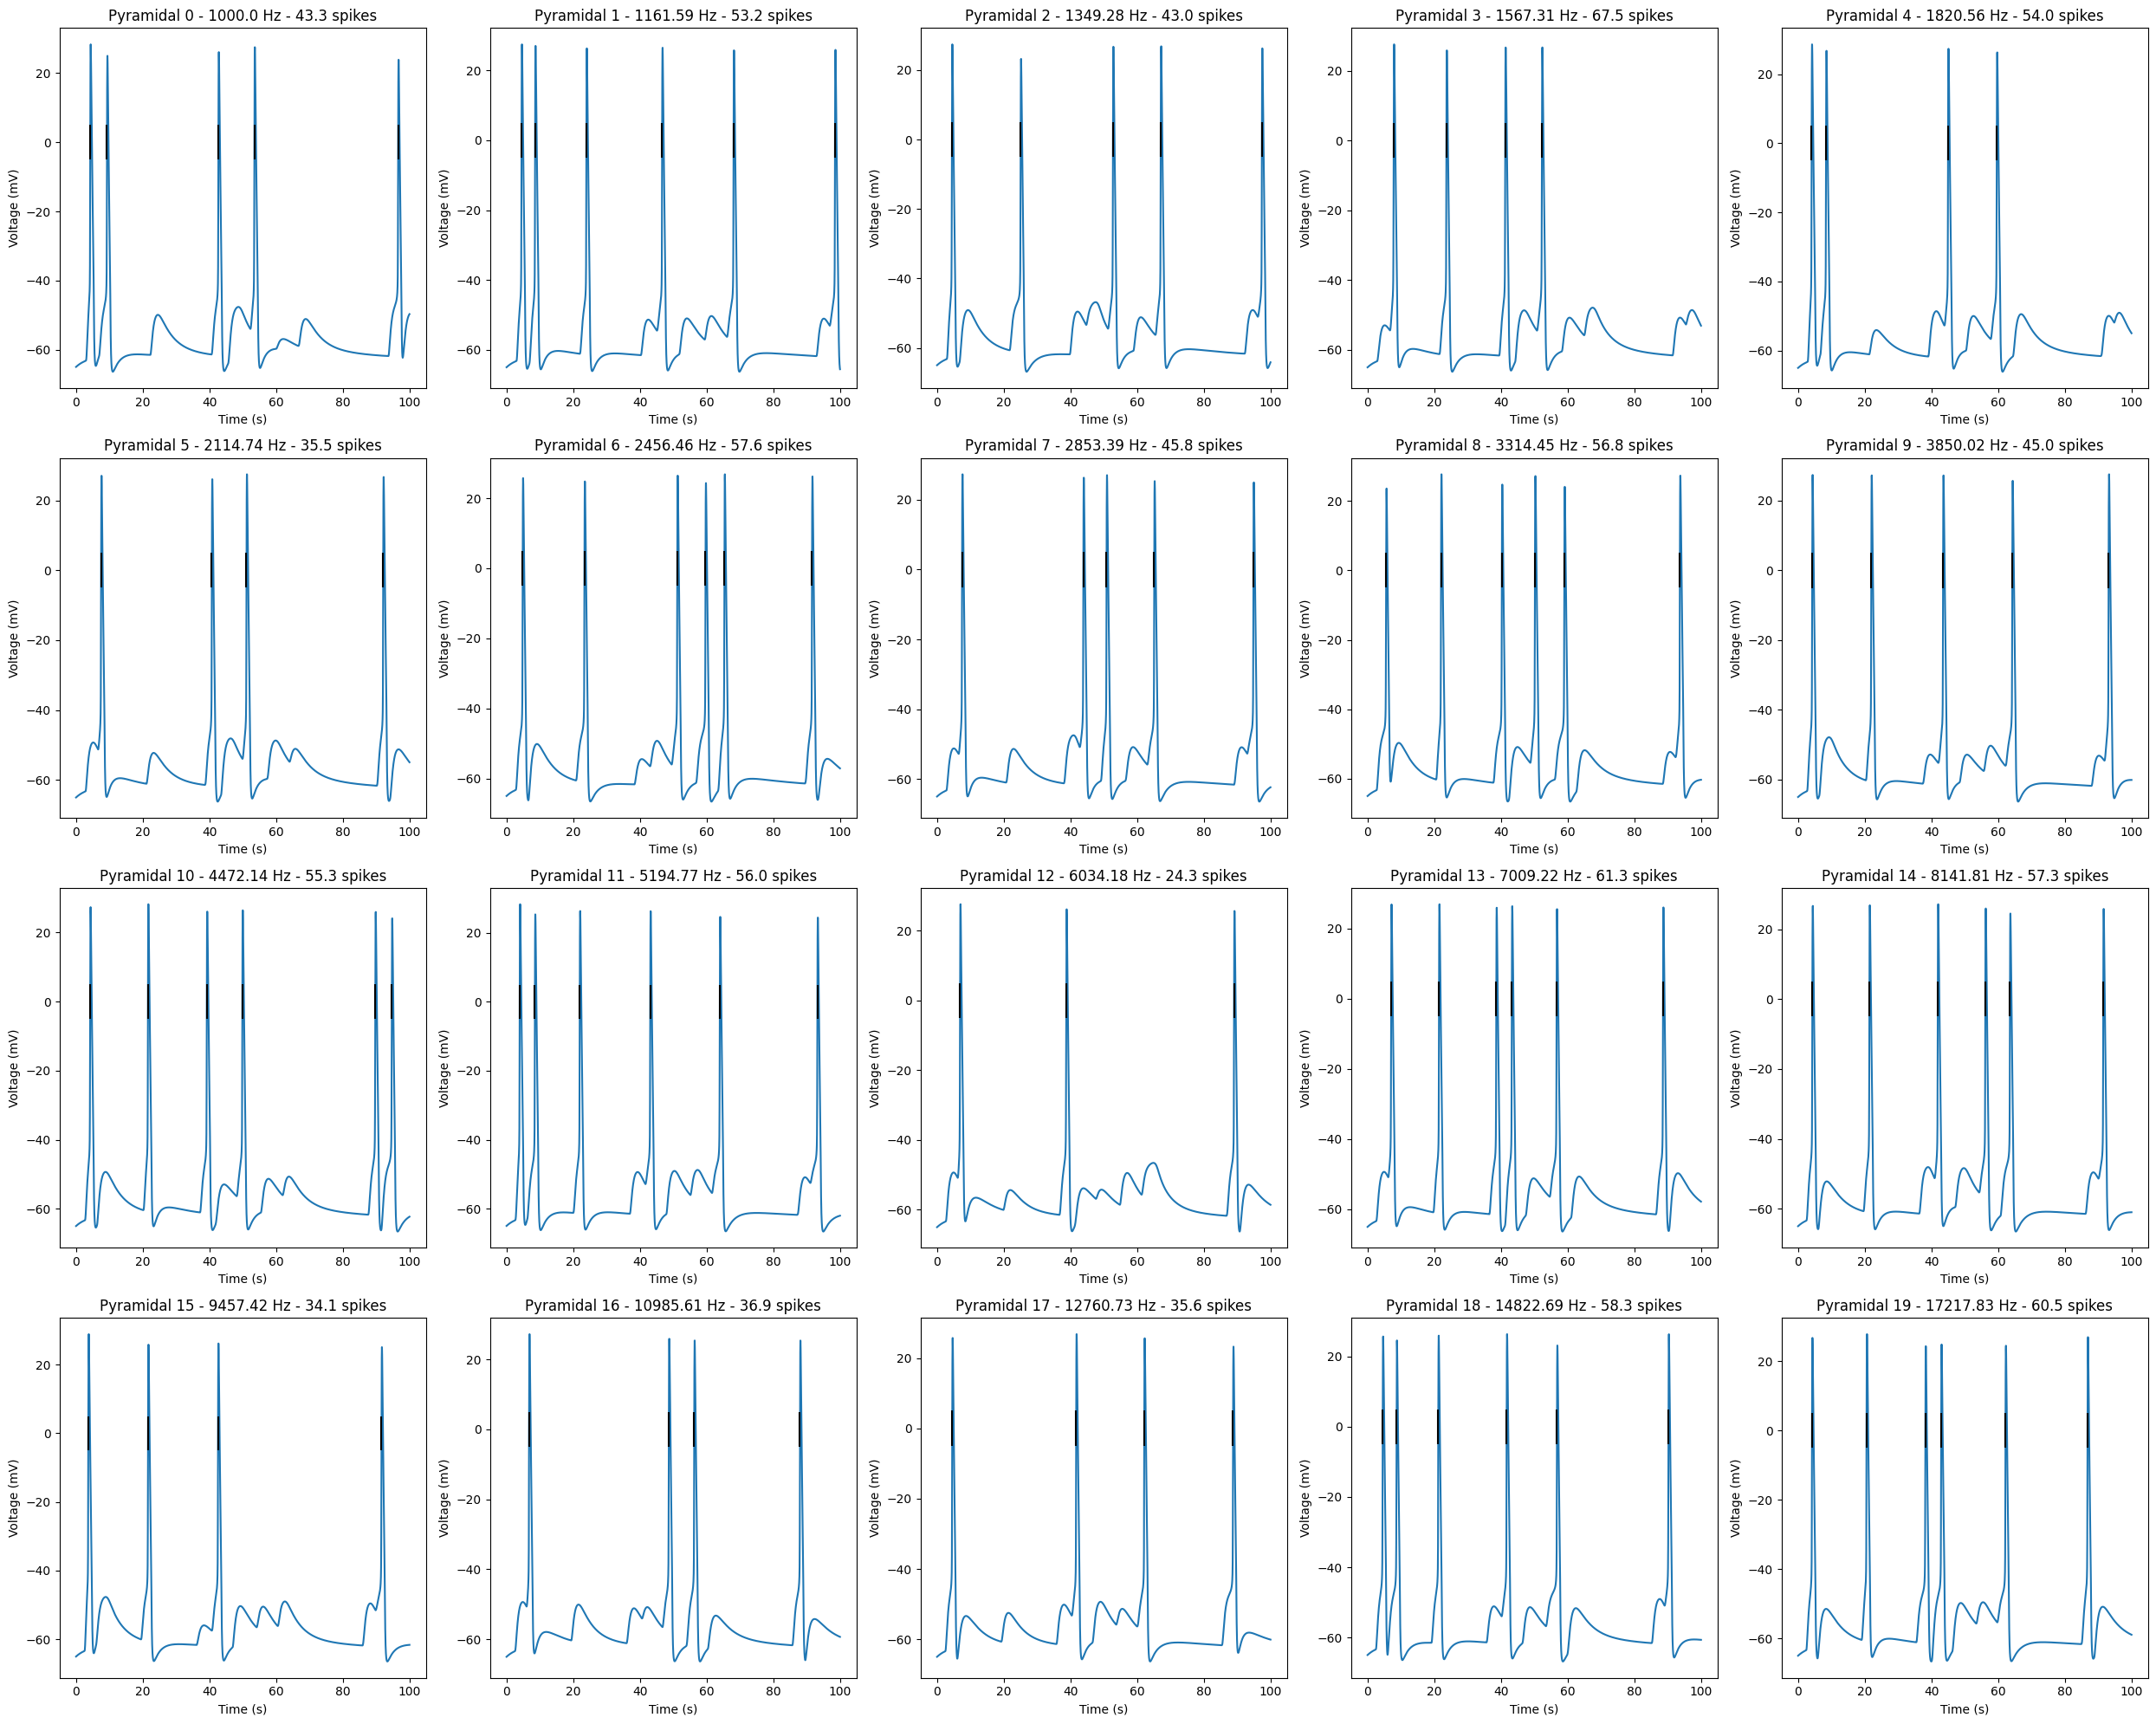

In [21]:
%matplotlib inline

fig, axs = plt.subplots(4,5,figsize=(25,20))
axs = axs.ravel()

for i, (spkt, v_pyr) in enumerate(zip(spkts, v_pyrs)):

    axs[i].plot(t, v_pyr, zorder=1)
    axs[i].vlines(spkt, ymin=-5, ymax=5, color='k', zorder=12)

    num_spikes = len(spkt)
    num_isi = num_spikes - 1 if num_spikes > 0 else 0
    msf = num_isi / (spkt[-1] - spkt[0]) * 1000

    axs[i].set_xlabel('Time (s)')
    axs[i].set_ylabel('Voltage (mV)')
    axs[i].set_title(f'Pyramidal {i} - {round(freqs[i],2)} Hz - {round(msf, 1)} spikes')

    # axs[row+1,i].plot(t, v_sgc)
    # axs[row+1,i].set_xlabel('Time (s)')
    # axs[row+1,i].set_ylabel('Voltage (mV)')
    # axs[row+1,i].set_title(f'SGC {freqs[i]} Hz')

fig.tight_layout()

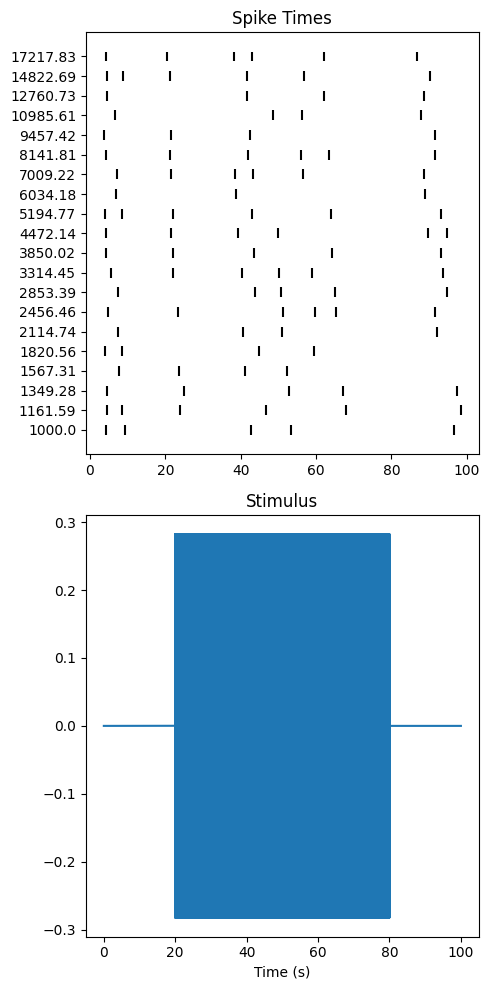

In [24]:
fig, axs = plt.subplots(2,1,figsize=(5,10))  #, sharex=True)
axs = axs.ravel()

axs[1].plot(stim.time, stim.sound)
axs[1].set_xlabel('Time (s)')
axs[1].set_title('Stimulus')

for i, spkt in enumerate(spkts):

    axs[0].vlines(spkt, ymin=i-0.25, ymax=i+0.25, color='k', zorder=12)

    num_spikes = len(spkt)
    num_isi = num_spikes - 1 if num_spikes > 0 else 0
    msf = num_isi / (spkt[-1] - spkt[0]) * 1000

axs[0].set_title('Spike Times')
axs[0].set_yticks(range(len(spkts)))
axs[0].set_yticklabels([round(freq, 2) for freq in freqs])

fig.tight_layout()
